In [17]:
import numpy as np
from itertools import combinations
from myf import calculate_g_xt, calculate_f_jk
from joblib import Parallel, delayed

def precompute_distances(profiles, n_jobs=-1,):
    n = len(profiles)
    # initial the matrix
    dtw_matrix = np.full((n, n), np.inf)
    indices = list(combinations(range(n), 2))
    
    # Calculate the score between 2 signals
    distances = Parallel(n_jobs=n_jobs)(
        delayed(calculate_f_jk)(
            profiles[i], profiles[j]
        ) for i,j in indices
    )
    
    # Assign score into matrix
    for (i, j), dist in zip(indices, distances):
        dtw_matrix[i, j] = dist

    masked_arr = np.ma.masked_where(np.isinf(dtw_matrix), dtw_matrix)
    return masked_arr

def single_motif(masked_arr,id, gamma=2):
    global profiles
    # Get minimum score
    min_value = masked_arr.min()
    if min_value < gamma:
        min_index = np.unravel_index(masked_arr.argmin(), masked_arr.shape)
        row, col = min_index

        motif = {
            "pattern1": profiles[row],
            "pattern2": profiles[col]
        }
        
        motif_info = {
            "idx": id,
            "motif": motif,
            "pair_idx": (row,col),
            "score": min_value,
        }

        return motif_info,masked_arr
    else: return None,masked_arr

def all_motifs(profiles,gamma,tau):

    motifs = []
    
    dtw_matrix = precompute_distances(profiles)

    motif, masked_arr = single_motif(dtw_matrix,1,gamma)
    while(True):
        motif, masked_arr = single_motif(masked_arr, len(motifs)+1,gamma)
        if motif is None:
            break

        motifs.append(motif)
        row, col = motif["pair_idx"]
        min_score = motif["score"]

        for i,dpx in enumerate(masked_arr[row]):
            
            if dpx < min_score + tau:
                masked_arr[i, :] = np.inf
                masked_arr[:, i] = np.inf 
        for j,dpy in enumerate(masked_arr[col]):
            if dpy < min_score + tau:
                masked_arr[j, :] = np.inf
                masked_arr[:, j] = np.inf 
    return motifs, masked_arr


In [18]:
if __name__ == "__main__":
    profiles = [
        (1.2, 3.4, 2.1),
        (1.1, 3.5, 2.0),
        (5.6, 4.2, 6.7),
        (5.5, 4.3, 6.6),
        (10.1, 12.3, 11.2),
    ]
    profiles = [
        (100, 120, 115),  # dp0
        (100, 120, 110),  # dp1
        (110, 110, 110),  # dp2
        (140, 60, 194),  # dp3
        (150, 50, 200),  # dp4
    ]
    gamma = 20.0  # 最大允许距离阈值
    tau = 0.5  # 容忍值

    # 并行计算
    motifs,masked_arr = all_motifs(profiles,1,0.5)
    for motif in motifs:
        print(motif)

{'idx': 1, 'motif': {'pattern1': (100, 120, 115), 'pattern2': (100, 120, 110)}, 'pair_idx': (np.int64(0), np.int64(1)), 'score': np.float64(0.054897198630034616)}
{'idx': 2, 'motif': {'pattern1': (140, 60, 194), 'pattern2': (150, 50, 200)}, 'pair_idx': (np.int64(3), np.int64(4)), 'score': np.float64(0.24098883878812788)}


In [9]:
def calculate_accuracy(x):
    reference = 14.8623
    return 1 - (abs(reference - x) / reference)

# 输入数据
data = {
    "0%": [14.5127, 14.8496, 14.748, 14.7461, 14.9512],
    "5%": [12.6953, 13.8594, 12.2246, 14.0801, 12.5537],
    "10%": [11.7725, 11.8232, 11.5918, 12.3418, 11.8896],
    "15%": [8.99414, 10.1533, 9.75781, 10.125, 9.01367],
    "20%": [8.47852, 8.9541, 8.32422, 8.31738, 8.9209],
    "25%": [7.20508, 6.65039, 6.87988, 7.34375, 8.22363],
    "30%": [6.38086, 6.27344, 5.02441, 5.07422, 5.84766],
    "35%": [3.02246, 4.0957, 4.34375, 4.24414, 5.31348],
    "40%": [4.7373, 2.87598, 1.39648, 2.4082, 3.0791],
    "45%": [0.96582,1.37109,0,1.30371,1.04004],
    "50%": [-0.0429688,0,0,0,0]
}

# 计算每个错误率下的平均准确率
for error_rate, values in data.items():
    avg = sum(x for x in values)/len(values)
    print(avg)
results = {}
for error_rate, values in data.items():
    accuracies = [calculate_accuracy(x) for x in values]
    # print(accuracies)
    avg_accuracy = sum(accuracies) / len(accuracies)
    results[error_rate] = avg_accuracy

# 打印结果
for error_rate, accuracy in results.items():
    print(f"{error_rate} 平均准确率: {accuracy:.4%}")

14.76152
13.08262
11.88378
9.608783999999998
8.599024
7.260546
5.720118
4.203906
2.8994120000000003
0.9361320000000001
-0.00859376
0% 平均准确率: 99.0826%
5% 平均准确率: 88.0255%
10% 平均准确率: 79.9592%
15% 平均准确率: 64.6521%
20% 平均准确率: 57.8580%
25% 平均准确率: 48.8521%
30% 平均准确率: 38.4874%
35% 平均准确率: 28.2857%
40% 平均准确率: 19.5085%
45% 平均准确率: 6.2987%
50% 平均准确率: -0.0578%


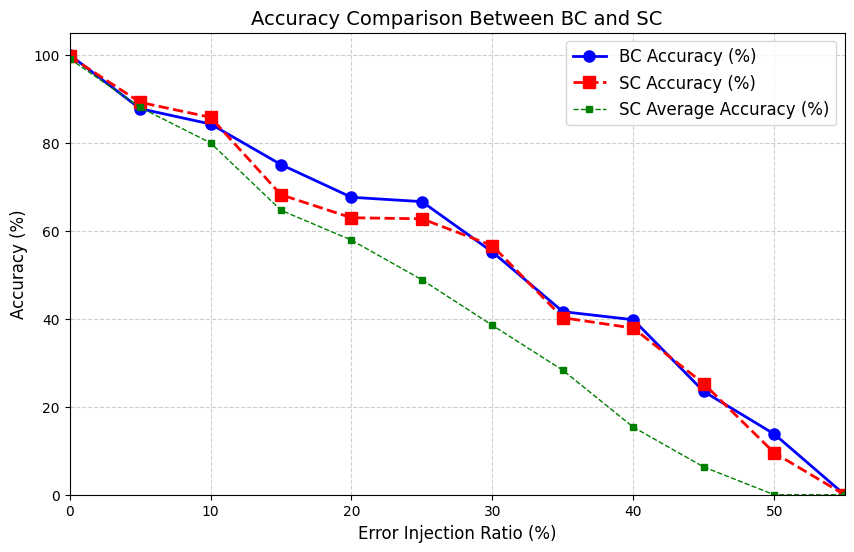

In [7]:
import matplotlib.pyplot as plt

# 數據
error_injection = [0.00, 5.00, 10.00, 15.00, 20.00, 25.00, 30.00, 35.00, 40.00, 45.00, 50.00, 55.00]
bc_accuracy = [100.00, 87.74, 84.25, 75.03, 67.60, 66.61, 55.17, 41.61, 39.77, 23.46, 13.80, 0.00]
sc_accuracy = [99.63, 89.18, 85.78, 68.17, 62.95, 62.71, 56.61, 40.23, 37.87, 25.24, 9.53, 0.00]
sc_avg_acc = [99.1,88.03,79.96,64.65,57.86,48.85,38.49,28.29,15.36,6.3,0,0]

# 創建圖形
plt.figure(figsize=(10, 6))
plt.plot(error_injection, bc_accuracy, 'b-o', label='BC Accuracy (%)', linewidth=2, markersize=8)
plt.plot(error_injection, sc_accuracy, 'r--s', label='SC Accuracy (%)', linewidth=2, markersize=8)
plt.plot(error_injection, sc_avg_acc, 'g--s', label='SC Average Accuracy (%)', linewidth=1, markersize=5)

# 添加標題和標籤
plt.title('Accuracy Comparison Between BC and SC', fontsize=14)
plt.xlabel('Error Injection Ratio (%)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=12)

# 設置坐標軸範圍
plt.xlim(0, 55)
plt.ylim(0, 105)

# 添加網格
plt.grid(True, linestyle='--', alpha=0.6)

# 顯示圖形
plt.show()